In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import PIL
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow_io")

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [24]:
import os
import shutil
from sklearn.model_selection import train_test_split
# Dataset base directory
base_dir1 = r'C:\Users\Avnish\Downloads\archive\Detect_solar_dust'  # Adjust if base_dir2 is different
base_dir2 = r'C:\Users\Avnish\Downloads\archive\Detect_solar_dust'
output_base = r'C:\Users\Avnish\OneDrive\Desktop\Solar_Data_Split'

# Dataset split target directories
target_root = r'C:\Users\Avnish\OneDrive\Desktop\Solar_Data_Split'
train_dir = os.path.join(target_root, 'train')
test_dir = os.path.join(target_root, 'test')
val_dir = os.path.join(target_root, 'validate')

# Classes
classes = ['Clean', 'Dusty']

# Create train, test, and validation directories
for base in [train_dir, test_dir, val_dir]:
    for cls in classes:
        path = os.path.join(base, cls)
        os.makedirs(path, exist_ok=True)

print("Folders created successfully.")


Folders created successfully.


In [29]:
def process_class(class_name):
    class_path1 = os.path.join(base_dir1, class_name)
    class_path2 = os.path.join(base_dir2, class_name)

    # Safety check
    if not os.path.exists(class_path1):
        print(f"❌ Directory not found: {class_path1}")
        return
    if not os.path.exists(class_path2):
        print(f"❌ Directory not found: {class_path2}")
        return

    # List files
    files1 = [os.path.join(class_path1, f) for f in os.listdir(class_path1) if os.path.isfile(os.path.join(class_path1, f))]
    files2 = [os.path.join(class_path2, f) for f in os.listdir(class_path2) if os.path.isfile(os.path.join(class_path2, f))]
    files = files1 + files2

    print(f"📂 Found {len(files)} total images for class '{class_name}'")

    # Split
    train_files, test_validate_files = train_test_split(files, test_size=0.3, random_state=42)
    test_files, validate_files = train_test_split(test_validate_files, test_size=(1/3), random_state=42)

    # Copy files
    for f in train_files:
        shutil.copy(f, os.path.join(train_dir, class_name, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(test_dir, class_name, os.path.basename(f)))
    for f in validate_files:
        shutil.copy(f, os.path.join(val_dir, class_name, os.path.basename(f)))

    # Print counts
    print(f"✅ {class_name} - Train: {len(train_files)}, Test: {len(test_files)}, Validate: {len(validate_files)}")


# Process each class
for class_name in classes:
    process_class(class_name)

print("✅ Dataset split and copied successfully!")


📂 Found 2986 total images for class 'Clean'
✅ Clean - Train: 2090, Test: 597, Validate: 299
📂 Found 2138 total images for class 'Dusty'
✅ Dusty - Train: 1496, Test: 428, Validate: 214
✅ Dataset split and copied successfully!


In [34]:
def count_files(path):
    return sum([len(files) for r, d, files in os.walk(path)])

# Update these paths to match your local output directory
train_counts = count_files(r'C:\Users\Avnish\OneDrive\Desktop\Solar_Data_Split\train')
test_counts = count_files(r'C:\Users\Avnish\OneDrive\Desktop\Solar_Data_Split\test')
validate_counts = count_files(r'C:\Users\Avnish\OneDrive\Desktop\Solar_Data_Split\validate')

print(f'Number of training files: {train_counts}')
print(f'Number of testing files: {test_counts}')
print(f'Number of validation files: {validate_counts}')


Number of training files: 2331
Number of testing files: 911
Number of validation files: 483


In [32]:
# Data augmentation and pre-processing using TensorFlow
BATCH_SIZE = 48
image_height = 299
image_width = 299

In [35]:
# Make sure to define these:
image_height = 224
image_width = 224
BATCH_SIZE = 32

train_generator = train_data_generator.flow_from_directory(
    directory=r"C:\Users\Avnish\OneDrive\Desktop\Solar_Data_Split\train",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=1234
)

test_generator = test_val_data_generator.flow_from_directory(
    directory=r"C:\Users\Avnish\OneDrive\Desktop\Solar_Data_Split\test",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=1234
)

validate_generator = test_val_data_generator.flow_from_directory(
    directory=r"C:\Users\Avnish\OneDrive\Desktop\Solar_Data_Split\validate",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=1234
)


Found 2331 images belonging to 2 classes.
Found 911 images belonging to 2 classes.
Found 483 images belonging to 2 classes.


In [36]:
# Get the mapping of class names to class indices
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))

# Extract the class names
class_names = list(dict_class.keys())
print('Class labels: {}'.format(class_names))

Dictionary: {'Clean': 0, 'Dusty': 1}
Class labels: ['Clean', 'Dusty']


In [37]:
# Print the dataset characteristics for the training set
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator.classes))
for class_name, class_index in train_generator.class_indices.items():
    print(f"Number of {class_name} images:", sum(train_generator.classes == class_index))

print()  # Add a newline for better readability

# Print the dataset characteristics for the test set
print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
for class_name, class_index in test_generator.class_indices.items():
    print(f"Number of {class_name} images:", sum(test_generator.classes == class_index))

print()  # Add a newline for better readability

# Print the dataset characteristics for the validation set
print("Dataset Characteristics of Validation Data Set:")
print("Number of images:", len(validate_generator.classes))
for class_name, class_index in validate_generator.class_indices.items():
    print(f"Number of {class_name} images:", sum(validate_generator.classes == class_index))

print()  # Add a newline for better readability

Dataset Characteristics of Train Data Set:
Number of images: 2331
Number of Clean images: 1359
Number of Dusty images: 972

Dataset Characteristics of Test Data Set:
Number of images: 911
Number of Clean images: 529
Number of Dusty images: 382

Dataset Characteristics of Validation Data Set:
Number of images: 483
Number of Clean images: 282
Number of Dusty images: 201



Train image data from Data Augmentation 1 *Preprocessing*


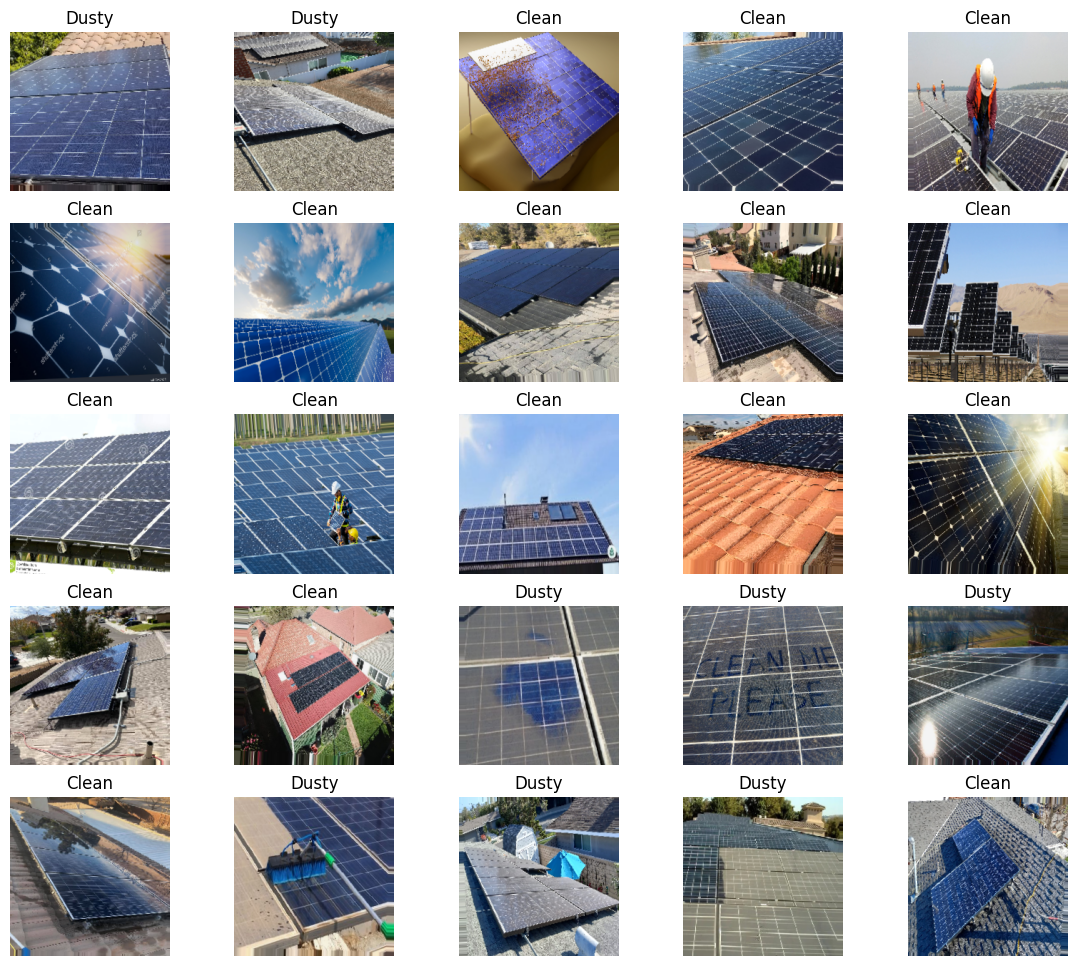

In [38]:
# Image Samples
print('Train image data from Data Augmentation 1 *Preprocessing*')
img, label = next(train_generator)

plt.figure(figsize=[14, 12])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

In [39]:
# Initialize VGG16 model with pre-trained weights on ImageNet,
# excluding the fully connected layers for feature extraction.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 40s 1us/step


In [40]:
# Weights of the VGG16 layers will not be updated during training. This is typical when using the model as a feature extractor.This means the weights of the VGG16 layers will not be updated during training
base_model.trainable = False 

In [41]:
# Add custom layers
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax')) 

In [42]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{np.int32(0): np.float64(0.8576158940397351),
 np.int32(1): np.float64(1.1990740740740742)}

In [44]:
epoch = 15
# model.fit(train_generator, validation_data=test_generator, epochs=epoch,
#     callbacks = [
#         tf.keras.callbacks.EarlyStopping(
#             monitor="val_loss",
#             min_delta=1e-2,
#             patience=3,
#             verbose=1,
#             restore_best_weights=True
#         )
#     ]
# )



# Train the model using the training generator, validating on the validation generator,
# specifying the number of epochs, and incorporating class weights for imbalanced datasets.
history = model.fit(train_generator, validation_data=validate_generator, epochs=epoch, class_weight=class_weights)


C:\Users\Avnish\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
12/73 ━━━━━━━━━━━━━━━━━━━━ 11:42 12s/step - accuracy: 0.5060 - loss: 3.2314

C:\Users\Avnish\tf-env\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 1006s 14s/step - accuracy: 0.5687 - loss: 1.7269 - val_accuracy: 0.7246 - val_loss: 0.5376
Epoch 2/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 1008s 14s/step - accuracy: 0.7409 - loss: 0.5184 - val_accuracy: 0.7681 - val_loss: 0.4723
Epoch 3/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 1059s 14s/step - accuracy: 0.7525 - loss: 0.5049 - val_accuracy: 0.7619 - val_loss: 0.4497
Epoch 4/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 1157s 16s/step - accuracy: 0.7685 - loss: 0.4619 - val_accuracy: 0.8364 - val_loss: 0.4179
Epoch 5/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 1254s 17s/step - accuracy: 0.7887 - loss: 0.4296 - val_accuracy: 0.8551 - val_loss: 0.3949
Epoch 6/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 927s 13s/step - accuracy: 0.8160 - loss: 0.3967 - val_accuracy: 0.8613 - val_loss: 0.3828
Epoch 7/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 813s 11s/step - accuracy: 0.8331 - loss: 0.3833 - val_accuracy: 0.7805 - val_loss: 0.4485
Epoch 8/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 832s 11s/step - accuracy: 0.8023 - loss: 0.3974 - val_accuracy: 0.8551 -

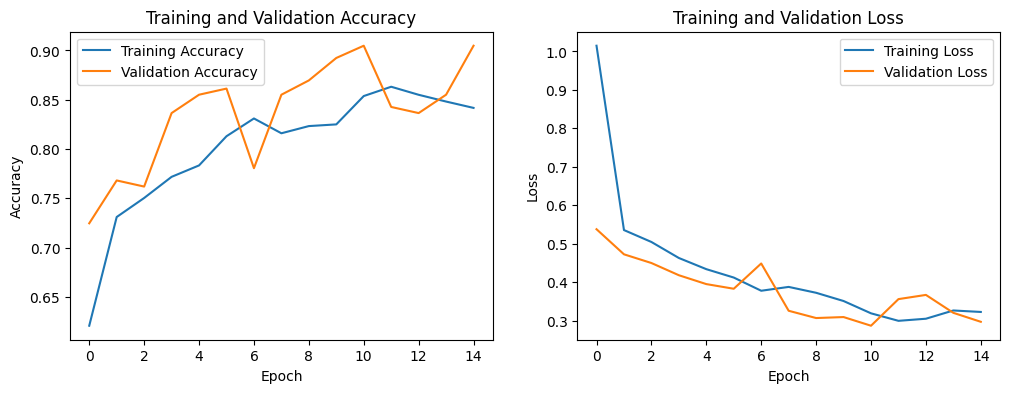

In [45]:
# Extract training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [46]:
# Evaluate the model on the test datawith class weights
evaluation = model.evaluate(test_generator)

# The evaluation result is a list containing the loss and any metrics you specified during model compilation
loss, accuracy = evaluation

print("Evaluation Results:")
print("Test Loss: {:.4f}".format(loss))
print("Test Accuracy: {:.2%}".format(accuracy))

29/29 ━━━━━━━━━━━━━━━━━━━━ 331s 11s/step - accuracy: 0.9312 - loss: 0.2129
Evaluation Results:
Test Loss: 0.2632
Test Accuracy: 91.55%


In [47]:
# Obtain true labels and predictions during testing
true_labels = []
predictions = []

# Reset the test generator to the beginning
test_generator.reset()

# Loop through the test generator to accumulate true labels and predictions
for i in range(len(test_generator)):
    images, labels = next(test_generator)
    true_labels.extend(labels)
    predictions_batch = model.predict(images)
    predictions.extend(predictions_batch)

# Convert lists to NumPy arrays
true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


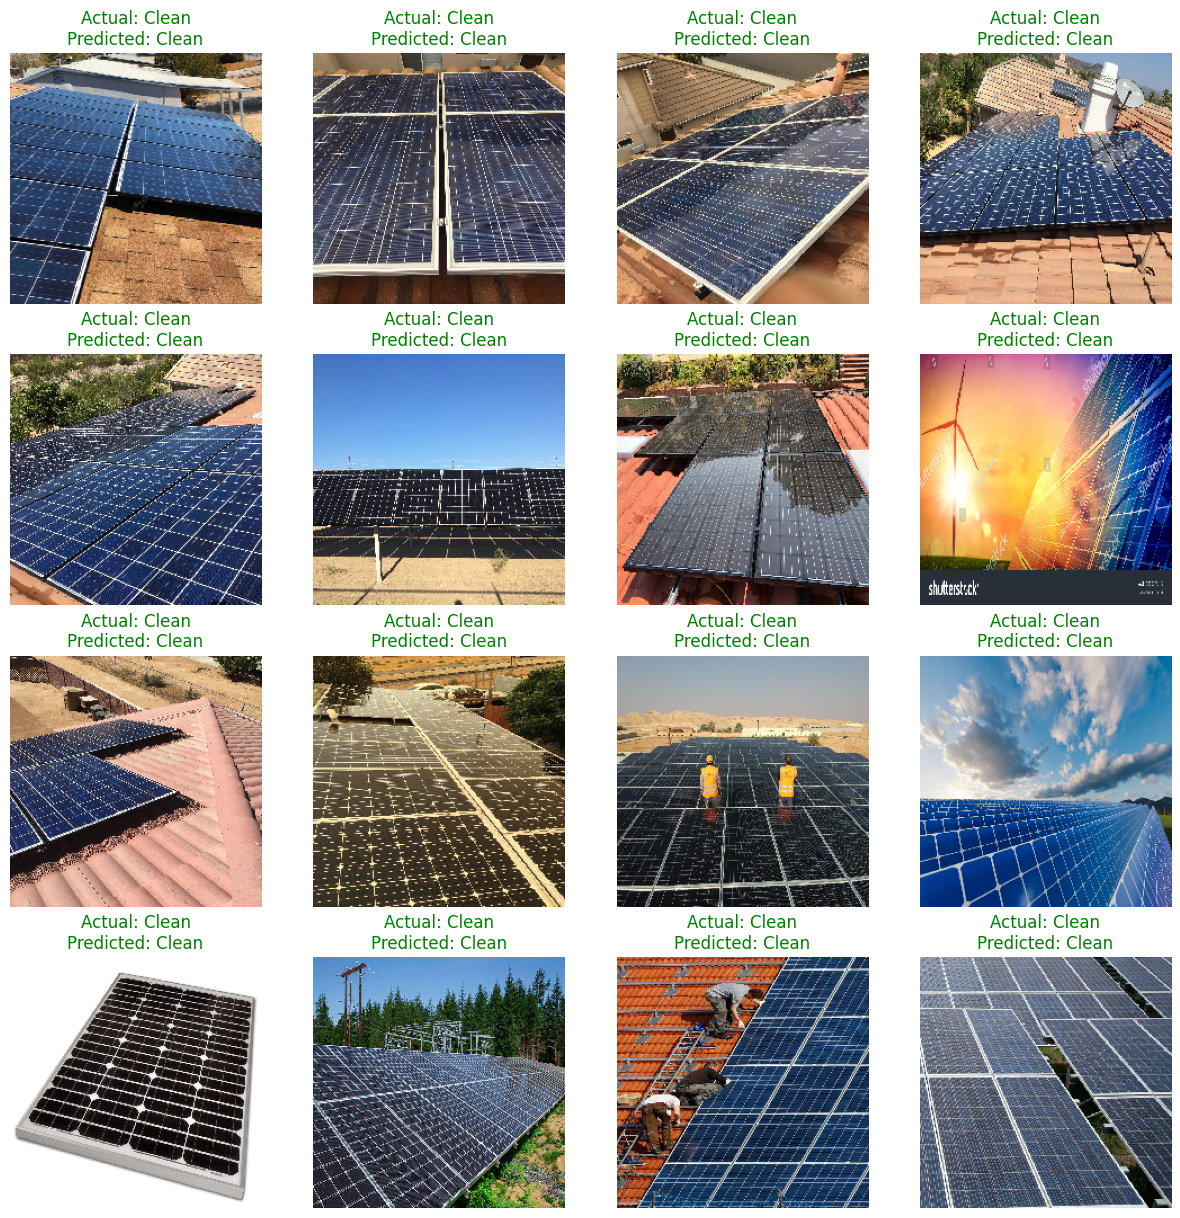

In [48]:
# Visualize a sample of images with true and predicted labels
num_samples = 16  # Change this based on how many samples you want to visualize

# Reset the test generator to the beginning
test_generator.reset()

# Obtain a batch of images and labels from the test generator
images, true_labels = next(test_generator)

# Predictions for the batch
predictions_batch = model.predict(images)

# Convert the batch predictions and true labels to NumPy arrays
predictions = np.argmax(predictions_batch, axis=1)
true_labels = np.argmax(true_labels, axis=1)

# Rescale pixel values to the range [0, 255]
images = (images * 255).astype("uint8")

# Visualize a sample of images with true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(min(num_samples, len(true_labels))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]) 
     
    if class_names[true_labels[i]] == class_names[predictions[i]]:
        title_color = 'green'
    else:
        title_color = 'red'
    
    plt.title("Actual: {}\nPredicted: {}".format(class_names[true_labels[i]], class_names[predictions[i]]), color=title_color)
    plt.axis("off")

plt.show()

In [54]:
# Save the entire model
model.save("dust_cleaning_cnn_model.h5")

print("✅ Model saved successfully as 'dust_cleaning_cnn_model.h5'")


✅ Model saved successfully as 'dust_cleaning_cnn_model.h5'


In [56]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the best model
model = load_model("dust_cleaning_cnn_model.h5")

# Predict on validation data
Y_pred = model.predict(validate_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validate_generator.classes

# Class labels
class_labels = list(validate_generator.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


12/16 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step

C:\Users\Avnish\tf-env\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 120s 7s/step
Classification Report:

              precision    recall  f1-score   support

       Clean       0.92      0.92      0.92       282
       Dusty       0.89      0.88      0.89       201

    accuracy                           0.90       483
   macro avg       0.90      0.90      0.90       483
weighted avg       0.90      0.90      0.90       483



<Figure size 600x600 with 0 Axes>

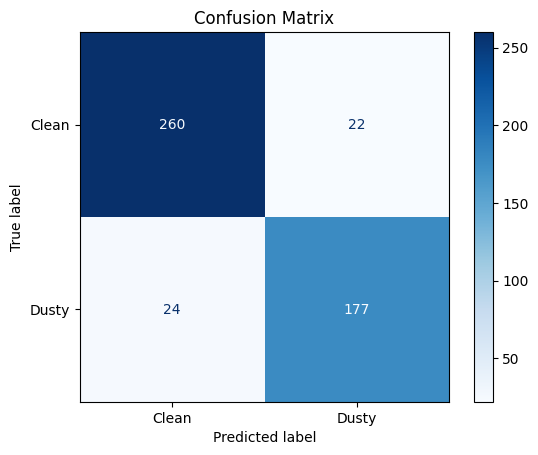

In [53]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [57]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("dust_cleaning_cnn_model.h5")

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [58]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('model_training_report.pdf') as pdf:
    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    pdf.savefig()
    plt.close()

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    pdf.savefig()
    plt.close()

    # You can add more plots if needed
